# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
import numpy as np
import pandas as pd

## Example Fit / Calibration

In [2]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(
                train[train[label] == h]["nHits"],
                range=(0, 300),
                bins=300,
                density=True,
            )[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(
                train[train[label] == h]["nClus"],
                range=(0, 300),
                bins=300,
                density=True,
            )[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(
                train[train[label] == h]["Edep"],
                range=(0, 3000),
                bins=300,
                density=True,
            )[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]]
            * self._clus[h][x["nClus"]]
            * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [6]:
label = "nPH"
num_dp = 30

data = pd.read_pickle(f"data/600AMeV_{num_dp}dp.trifeature.pkl")
msk = np.random.rand(len(data)) < 0.8
# Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
msk[0] = True
traindata.loc[0] = [0, 0, 0, 0, 0, 0]
traindata = data[msk]
testdata = data[~msk]

model = Bayes(traindata, 5, label)
y_pred = model.predict(testdata)
y_true = testdata[label].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(3, 4), (1, 1), (2, 2), (3, 4), (4, 4), (3, 3), (5, 5), (1, 1), (3, 3), (4, 4), (1, 1), (0, 0), (2, 2), (1, 1), (2, 2), (4, 4), (3, 3), (5, 5), (5, 4), (1, 1), (2, 3), (2, 2), (5, 5), (3, 3), (2, 2), (5, 5), (3, 3), (5, 5), (4, 5), (5, 5), (3, 4), (1, 1), (2, 2), (4, 4), (1, 1), (5, 5), (4, 4), (1, 2), (1, 1), (1, 1), (5, 3), (5, 5), (5, 5), (2, 2), (1, 1), (0, 0), (1, 1), (4, 4), (5, 4), (3, 3)]


## Example Prediction

In [7]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

0.7403339275243978
[[  4775      0      0      0      0      0]
 [     0 189702  14427      4      0      0]
 [     0  30415 142115  31336    221      0]
 [     0   2003  41057 119204  40643   1183]
 [     0     84   4527  45907 103054  49016]
 [     3      6    271   6631  43032 130741]]
[[1.    0.    0.    0.    0.    0.   ]
 [0.    0.929 0.071 0.    0.    0.   ]
 [0.    0.149 0.696 0.154 0.001 0.   ]
 [0.    0.01  0.201 0.584 0.199 0.006]
 [0.    0.    0.022 0.227 0.509 0.242]
 [0.    0.    0.001 0.037 0.238 0.724]]


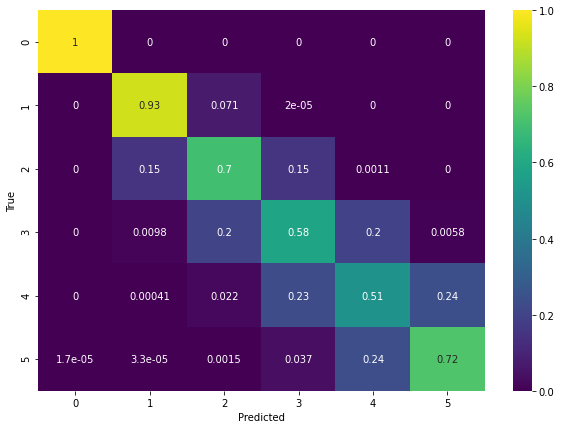

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True");

## Evaluation for different max multiplicities

In [20]:
bac_scores = {}
for num_dp in [15, 30]:
    for n in range(2, 6):
        data = pd.read_pickle(f"data/600AMeV_{num_dp}dp.trifeature.pkl")
        data = data[data["nPN"] <= n] 
        msk = np.random.rand(len(data)) < 0.8
        # Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
        msk[0] = True
        msk[1] = False
        data.loc[0] = data.loc[1] = [0, 0, 0, 0, 0, 0]
        traindata = data[msk]
        testdata = data[~msk]

        for label in ["nPH"]:
            model = Bayes(traindata, n, label)
            y_pred = model.predict(testdata)
            y_true = testdata[label].values.ravel()
            # print(list(zip(y_true, y_pred))[0:50])
            bac = balanced_accuracy_score(y_true, y_pred)
            print(num_dp, n, label, bac)

15 2 nPH 0.8668922371269447
15 3 nPH 0.763352329448435
15 4 nPH 0.6872762550754925
15 5 nPH 0.6273321168591969
30 2 nPH 0.9268170270848577
30 3 nPH 0.8540811527209101
30 4 nPH 0.7924763599561359
30 5 nPH 0.7407227603853421
